In [2]:
import os
import requests
import tarfile

def download_cifar10(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024
    with open(save_path, 'wb') as f:
        for data in response.iter_content(chunk_size=chunk_size):
            f.write(data)
            downloaded_size = os.path.getsize(save_path)
            progress = 100 * downloaded_size / total_size
            print('\rDownloading: {:.2f}%'.format(progress), end='', flush=True)
    print("\nDownload completed!")

# Download CIFAR-10 dataset
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
save_path = "./cifar-10-python.tar.gz"
download_cifar10(cifar10_url, save_path)

KeyboardInterrupt: 

In [3]:
import tarfile

def extract_cifar10(archive_path, extract_dir):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_dir)
    print("Extraction completed!")

archive_path = "/home/atharva/Documents/GitHub/Object_Recognition/Object Recognition/cifar-10-python.tar.gz"
extract_dir = "cifar-10-python"
extract_cifar10(archive_path, extract_dir)


EOFError: Compressed file ended before the end-of-stream marker was reached

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pickle
def load_cifar10(data_dir):
    images = []
    labels = []
    try:
        for file in os.listdir(data_dir):
            if file.startswith('data_batch') or file.startswith('test_batch'):
                with open(os.path.join(data_dir, file), 'rb') as fo:
                    cifar_data = pickle.load(fo, encoding='bytes')
                    for i, image_data in enumerate(cifar_data[b'data']):
                        # CIFAR-10 images are in CHW format (channels, height, width)
                        # Reshape the image to HWC format (height, width, channels)
                        image = np.transpose(np.reshape(image_data, (3, 32, 32)), (1, 2, 0))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        label = cifar_data[b'labels'][i]
                        images.append(image)
                        labels.append(label)
    except Exception as e:
        print("Error loading CIFAR-10 dataset:", e)
    return np.array(images), np.array(labels)


# Function to preprocess images
def preprocess_images(images):
    # Resize images to a fixed size (e.g., 32x32)
    resized_images = [cv2.resize(image, (64, 64)) for image in images]
    processed_images = np.array(resized_images, dtype=np.float32) / 255.0
    return processed_images

data_dir = 'cifar-10-python/cifar-10-batches-py'
images, labels = load_cifar10(data_dir)

processed_images = preprocess_images(images)

X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Image shape:", X_train[0].shape)
print("Number of classes:", len(np.unique(y_train)))


Error loading CIFAR-10 dataset: pickle data was truncated
Number of training samples: 8000
Number of test samples: 2000
Image shape: (64, 64)
Number of classes: 10


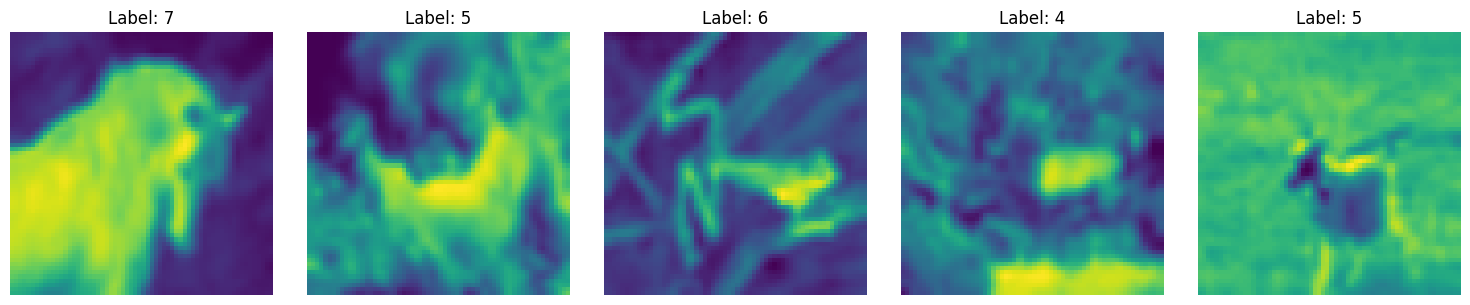

In [9]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title("Label: {}".format(labels[i]))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X_train[:5], y_train[:5])


In [3]:
### d)
from sklearn.cluster import KMeans

def compress_image_sklearn(image, k):
    pixels = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    compressed_pixels = kmeans.cluster_centers_[kmeans.labels_]
    compressed_image = np.reshape(compressed_pixels, image.shape)
    return compressed_image

In [4]:
from scipy.ndimage import gaussian_filter
def compress_blur_image(image, k):
    blurred_image = gaussian_filter(image, sigma=1)
    pixels = np.reshape(blurred_image, (-1, 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    compressed_pixels = kmeans.cluster_centers_[kmeans.labels_]
    compressed_image = np.reshape(compressed_pixels, blurred_image.shape)
    return compressed_image

In [64]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

#X_train_flat = [gaussian_filter(i, sigma = 1) for i in X_train_flat ]
#X_test_flat = [gaussian_filter(i, sigma = 1) for i in X_test_flat ]

In [7]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)



print("Shape of PCA-transformed training data:", X_train_pca.shape)


Shape of PCA-transformed training data: (8000, 79)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Create a Random Forest Classifier
clf_pca = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data transformed by PCA
clf_pca.fit(X_train_pca, y_train)


RandomForestClassifier(random_state=42)

In [18]:
# Make predictions on the testing data transformed by PCA
y_pred_pca = clf_pca.predict(X_test_pca)


# Evaluate the performance of the model
print("Accuracy of PCA-transformed data:", accuracy_score(y_test, y_pred_pca))

Accuracy of PCA-transformed data: 0.359
Accuracy of LDA-transformed data: 0.1545


In [17]:
from sklearn.neighbors import KNeighborsClassifier



knn = KNeighborsClassifier(n_neighbors=5)
#check
knn.fit(X_train_pca, y_train)

y_pred_pca = knn.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy on PCA-transformed test data:", accuracy_pca)

knn.fit(X_train_lda, y_train)

y_pred_lda = knn.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy on LDA-transformed test data:", accuracy_lda)


Accuracy on PCA-transformed test data: 0.2745
Accuracy on LDA-transformed test data: 0.1555


In [12]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [65]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Assuming X_train_pca and y_train are numpy arrays or PyTorch tensors
# Convert them to PyTorch tensors if they are not already
X_train_pca_tensor = torch.tensor(X_train_pca)
y_train_tensor = torch.tensor(y_train)

# Combine X_train_pca and y_train into a single dataset
train_dataset_pca = TensorDataset(X_train_pca_tensor, y_train_tensor)

# Assuming X_test_pca and y_test are numpy arrays or PyTorch tensors
# Convert them to PyTorch tensors if they are not already
X_test_pca_tensor = torch.tensor(X_test_pca)
y_test_tensor = torch.tensor(y_test)

# Combine X_test_pca and y_test into a single dataset
test_dataset_pca = TensorDataset(X_test_pca_tensor, y_test_tensor)

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Define transformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),      # Randomly rotate the image by a maximum of 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Randomly translate the image horizontally and vertically by a maximum of 10% of its size
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize the image tensor
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Apply transformations to train and test datasets
train_dataset_pca.transform = transform_train
test_dataset_pca.transform = transform_test

# Create DataLoader instances with the combined dataset
train_dataloader_pca = DataLoader(train_dataset_pca, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_pca = DataLoader(test_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Train DataLoader pca: {train_dataloader_pca}")
print(f"Test DataLoader pca: {test_dataloader_pca}")
print(f"Length of train dataloader pca: {len(train_dataloader_pca)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader pca: {len(test_dataloader_pca)} batches of {BATCH_SIZE}")


Train DataLoader pca: <torch.utils.data.dataloader.DataLoader object at 0x7d6dea88f580>
Test DataLoader pca: <torch.utils.data.dataloader.DataLoader object at 0x7d6e02441b10>
Length of train dataloader pca: 250 batches of 32
Length of test dataloader pca: 63 batches of 32


In [66]:
X_train_tensor = torch.tensor(X_train_flat)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_test_pca_tensor = torch.tensor(X_test_flat)

test_dataset = TensorDataset(X_test_pca_tensor, y_test_tensor)
train_dataset.transform = transform_train
test_dataset.transform = transform_test

# Create DataLoader instances with the combined dataset
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Train DataLoader: {train_dataloader}")
print(f"Test DataLoader: {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7d6e02443730>
Test DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7d6e02442500>
Length of train dataloader: 250 batches of 32
Length of test dataloader: 63 batches of 32


In [10]:
print(next(iter(train_dataloader))[0].shape)

torch.Size([32, 4096])


In [13]:
# Create a model with non-linear and linear layers
class ObjectRecognition(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, hidden_units1: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = x.to(torch.float32)
        return self.layer_stack(x)

In [94]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = ObjectRecognition(input_shape=79, 
    hidden_units=128,# one for every pixel (28x28)
    hidden_units1=64, # how many units in the hiden layer
    output_shape=10 # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

ObjectRecognition(
  (layer_stack): Sequential(
    (0): Linear(in_features=79, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [86]:
model_1 = ObjectRecognition(input_shape=4096, # one for every pixel (28x28)
    hidden_units=1024,
    hidden_units1=512, # how many units in the hiden layer
    output_shape=10 # one for every class
)
model_1.to("cpu") # keep model on CPU to begin with

ObjectRecognition(
  (layer_stack): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [69]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = 'cpu'):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, XX in enumerate(data_loader):
        # Convert each element of the list to a tensor
        X = XX[0]
        y = XX[1]
        X = X.to(device)  # Move X to the same device as the model parameters
        X = X.to(torch.float32)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
     
        loss = loss_fn(y_pred, y)
        #loss += loss_fn(y_pred.to(torch.float32), y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = 'cpu'):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for batch, XX in enumerate(data_loader):
            # Convert each element of the list to a tensor
            X = XX[0]
            y = XX[1]
            X = X.to(device)  # Move X to the same device as the model parameters
            X = X.to(torch.float32)
            test_pred = model(X)
            # 2. Calculate loss and accuracy
        
            test_loss += loss_fn(test_pred,y)
            #loss += loss_fn(test_pred.to(torch.float32), y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")

In [87]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [28]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [21]:
def accuracy_fn(y_true, y_pred):
 
    correct = (y_true == y_pred).sum()

    # Calculate the accuracy
    accuracy = correct / len(y_true)

    return accuracy

In [88]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.19967 | Train accuracy: 17.58%
Test loss: 2.07335 | Test accuracy: 24.95%

Epoch: 1
---------
Train loss: 2.05580 | Train accuracy: 25.12%
Test loss: 1.98936 | Test accuracy: 26.34%

Epoch: 2
---------
Train loss: 1.99887 | Train accuracy: 28.40%
Test loss: 1.94901 | Test accuracy: 30.36%

Epoch: 3
---------
Train loss: 1.94892 | Train accuracy: 29.82%
Test loss: 1.95858 | Test accuracy: 29.96%

Epoch: 4
---------
Train loss: 1.92056 | Train accuracy: 30.67%
Test loss: 1.93665 | Test accuracy: 30.31%

Epoch: 5
---------
Train loss: 1.88643 | Train accuracy: 32.64%
Test loss: 1.89473 | Test accuracy: 31.15%

Epoch: 6
---------
Train loss: 1.85410 | Train accuracy: 33.26%
Test loss: 1.87516 | Test accuracy: 33.48%

Epoch: 7
---------
Train loss: 1.83320 | Train accuracy: 34.21%
Test loss: 1.86872 | Test accuracy: 33.38%

Epoch: 8
---------
Train loss: 1.81446 | Train accuracy: 35.01%
Test loss: 1.87385 | Test accuracy: 32.29%

Epoch: 9
---------
Train los

In [100]:
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=0.00001) 

In [101]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader_pca,
        model=model_0,
        loss_fn=loss_fn,
        optimizer=optimizer_0,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader_pca,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.97125 | Train accuracy: 67.25%
Test loss: 1.81670 | Test accuracy: 39.83%

Epoch: 1
---------
Train loss: 0.96966 | Train accuracy: 67.30%
Test loss: 1.81662 | Test accuracy: 39.93%

Epoch: 2
---------
Train loss: 0.96875 | Train accuracy: 67.39%
Test loss: 1.81746 | Test accuracy: 39.88%

Epoch: 3
---------
Train loss: 0.96805 | Train accuracy: 67.26%
Test loss: 1.81783 | Test accuracy: 39.83%

Epoch: 4
---------
Train loss: 0.96740 | Train accuracy: 67.33%
Test loss: 1.81855 | Test accuracy: 39.83%

Epoch: 5
---------
Train loss: 0.96675 | Train accuracy: 67.26%
Test loss: 1.81909 | Test accuracy: 39.93%

Epoch: 6
---------
Train loss: 0.96605 | Train accuracy: 67.21%
Test loss: 1.82002 | Test accuracy: 39.88%

Epoch: 7
---------
Train loss: 0.96542 | Train accuracy: 67.35%
Test loss: 1.82036 | Test accuracy: 39.83%

Epoch: 8
---------
Train loss: 0.96483 | Train accuracy: 67.38%
Test loss: 1.82090 | Test accuracy: 39.73%

Epoch: 9
---------
Train los

In [102]:
# Create a model with non-linear and linear layers
class ObjectRecognition_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, hidden_units1: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units1, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = x.to(torch.float32)
        return self.layer_stack(x)

In [92]:
model_1_1 = ObjectRecognition_1(input_shape=4096, # one for every pixel (28x28)
    hidden_units=1024,
    hidden_units1=512, # how many units in the hiden layer
    output_shape=10 # one for every class
)
model_1.to("cpu") # keep model on CPU to begin with

ObjectRecognition(
  (layer_stack): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [108]:
model_0_1 = ObjectRecognition_1(input_shape=79, # one for every pixel (28x28)
    hidden_units=128,
    hidden_units1=64, # how many units in the hiden layer
    output_shape=10 # one for every class
)
model_0_1.to("cpu") # keep model on CPU to begin with

ObjectRecognition_1(
  (layer_stack): Sequential(
    (0): Linear(in_features=79, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [114]:
optimizer_1_1 = torch.optim.Adam(model_1_1.parameters(), lr=0.0001) 

In [115]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1_1,
        loss_fn=loss_fn,
        optimizer=optimizer_1_1,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.69226 | Train accuracy: 39.40%
Test loss: 1.82299 | Test accuracy: 35.12%

Epoch: 1
---------
Train loss: 1.66798 | Train accuracy: 40.70%
Test loss: 1.81415 | Test accuracy: 35.62%

Epoch: 2
---------
Train loss: 1.65615 | Train accuracy: 40.79%
Test loss: 1.81262 | Test accuracy: 36.31%

Epoch: 3
---------
Train loss: 1.64578 | Train accuracy: 40.98%
Test loss: 1.81305 | Test accuracy: 35.22%

Epoch: 4
---------
Train loss: 1.63651 | Train accuracy: 41.19%
Test loss: 1.81625 | Test accuracy: 35.37%

Epoch: 5
---------
Train loss: 1.62687 | Train accuracy: 41.88%
Test loss: 1.80748 | Test accuracy: 37.10%

Epoch: 6
---------
Train loss: 1.61405 | Train accuracy: 42.21%
Test loss: 1.82207 | Test accuracy: 34.62%

Epoch: 7
---------
Train loss: 1.60851 | Train accuracy: 42.64%
Test loss: 1.80531 | Test accuracy: 36.01%

Epoch: 8
---------
Train loss: 1.59665 | Train accuracy: 43.09%
Test loss: 1.81286 | Test accuracy: 34.92%

Epoch: 9
---------
Train los

In [112]:
optimizer_0_1 = torch.optim.Adam(model_0_1.parameters(), lr=0.0001) 

In [113]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader_pca,
        model=model_0_1,
        loss_fn=loss_fn,
        optimizer=optimizer_0_1,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader_pca,
        model=model_0_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09262 | Train accuracy: 62.84%
Test loss: 1.74250 | Test accuracy: 41.27%

Epoch: 1
---------
Train loss: 1.07250 | Train accuracy: 63.66%
Test loss: 1.74695 | Test accuracy: 41.77%

Epoch: 2
---------
Train loss: 1.06271 | Train accuracy: 64.04%
Test loss: 1.75179 | Test accuracy: 41.37%

Epoch: 3
---------
Train loss: 1.05379 | Train accuracy: 64.26%
Test loss: 1.76057 | Test accuracy: 40.77%

Epoch: 4
---------
Train loss: 1.04633 | Train accuracy: 64.42%
Test loss: 1.76119 | Test accuracy: 40.77%

Epoch: 5
---------
Train loss: 1.03925 | Train accuracy: 64.79%
Test loss: 1.76763 | Test accuracy: 40.67%

Epoch: 6
---------
Train loss: 1.03142 | Train accuracy: 64.96%
Test loss: 1.78237 | Test accuracy: 39.78%

Epoch: 7
---------
Train loss: 1.02561 | Train accuracy: 65.30%
Test loss: 1.77840 | Test accuracy: 40.67%

Epoch: 8
---------
Train loss: 1.01901 | Train accuracy: 65.40%
Test loss: 1.78345 | Test accuracy: 40.33%

Epoch: 9
---------
Train los